In [6]:

import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
from tqdm import tqdm
np.random.seed(42)



In [7]:
def generate_mu_sigma(P_d, T):
    """
    生成一条长度为 T 的 mu 和 sigma，符合给定扰动规则。
    参数:
    - P_d: 节点负荷基准值
    - T: 时长（通常为24）
    """
    mu = np.zeros(T)
    sigma = np.zeros(T)

    # 初始值
    mu[0] = np.random.uniform(0.5 * P_d, 1.5 * P_d)
    CV = np.random.uniform(0.05, 0.3)
    sigma[0] = CV * mu[0]

    for t in range(1, T):
        lower_delta = max(-0.2 * P_d, 0.5 * P_d - mu[t-1])
        upper_delta = min(0.2 * P_d, 1.5 * P_d - mu[t-1])
        delta = np.random.uniform(lower_delta, upper_delta)

        mu[t] = mu[t-1] + delta
        CV = np.random.uniform(0.05, 0.3)
        sigma[t] = CV * mu[t]

    return mu, sigma


from scipy.stats import truncnorm

def generate_TN_distributions(mu, sigma):
    """
    返回每个时刻 t 的截断正态分布对象，用于采样
    参数:
    - mu: list or array of length T
    - sigma: list or array of length T
    返回:
    - tn_dists: list of truncnorm distribution objects, each can be sampled later
    """
    tn_dists = []
    for m, s in zip(mu, sigma):
        a, b = -2, 2  # 截断范围为 ±2σ（标准正态化）
        dist = truncnorm(a=a, b=b, loc=m, scale=s)
        tn_dists.append(dist)

    return tn_dists


In [8]:
mu = [0.0, 1.0, 2.0]
sigma = [1.0, 0.5, 1.5]

# 使用版本3（最实用）
distributions = generate_TN_distributions(mu, sigma)

# 采样示例
for i, dist in enumerate(distributions):
    samples = dist.rvs((5,))  # 采样5个点
    print(f"Distribution {i+1} (mu={mu[i]}, sigma={sigma[i]}):")
    print(f"Samples: {samples}")
    print()

Distribution 1 (mu=0.0, sigma=1.0):
Samples: [-0.304828    1.47733214  0.58711915  0.23828377 -0.94758696]

Distribution 2 (mu=1.0, sigma=0.5):
Samples: [0.52616131 0.2913271  1.51717782 1.12216742 1.26019659]

Distribution 3 (mu=2.0, sigma=1.5):
Samples: [-0.58526737  4.44613027  3.3577781   0.86901572  0.71764328]



In [9]:


bus_df = pandas.read_csv(r"D:\tools\workspace_pycharm\sddip-SCUC-6-24\data\01_test_cases/case6ww/raw/bus_data.txt",sep = '\t')

pd_list = bus_df["Pd"].tolist()
print(pd_list)

pd_re_list = pd_list + [0] * len(pd_list)
print(pd_re_list)


[0, 0, 0, 70, 70, 70]
[0, 0, 0, 70, 70, 70, 0, 0, 0, 0, 0, 0]


In [10]:
# num_samples = 300
# T = 24
# P_d = 70
#
# plt.figure(figsize=(12, 6))
# cmap = plt.cm.get_cmap('jet', num_samples)
# for i in range(num_samples):
#     mu, _ = generate_mu_sigma(P_d, T)
#     plt.plot(range(1, T+1), mu, color=cmap(i), alpha=0.1)  # 透明度设置为0.1
#
# plt.xlabel('Hour (t)')
# plt.ylabel('μ Value')
# plt.title(f'{num_samples} Samples of 24-Hour μ Profiles')
# plt.xticks(range(1, T+1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [11]:
def generate_df(
        storage_path,
        start,
        n_samples,
        n_stages = 24,
        n_bus = 6,
        n_realizations = 6
        ):

    mu_plot_list = []
    mu_plot_list1 = []
    for index in tqdm(range(start, start + n_samples), desc="Generating df"):


        parameter_columns = []
        parameter_columns.append("t")
        scenario_columns = []
        scenario_columns.append("t")
        scenario_columns.append("n")
        scenario_columns.append("p")
        for j in range(n_bus):
            parameter_columns.append(f"Pd{j+1}")
        for j in range(n_bus):
            parameter_columns.append(f"Pd{j+1}_sigma")

        for j in range(n_bus):
            scenario_columns.append(f"Pd{j+1}")
        for j in range(n_bus):
            scenario_columns.append(f"Re{j+1}")

        # parameter_columns = "t	Pd1	Pd2	Pd3	Pd4	Pd5	Pd6	Pd1_sigma	Pd2_sigma	Pd3_sigma	Pd4_sigma	Pd5_sigma	Pd6_sigma".split("\t")
        # print(parameter_columns)
        # scenario_columns = "t	n	p	Pd1	Pd2	Pd3	Pd4	Pd5	Pd6	Re1	Re3	Re4	Re5	Re6	Re2".split("\t")
        # print(scenario_columns)
        parameter_df = pandas.DataFrame(columns=parameter_columns)
        scenario_df = pandas.DataFrame(columns=scenario_columns)
        mu_bus_list = []
        sigma_bus_list = []
        dist_bus_list = []
        for pd in pd_list:
            if pd != 0:
                mu, sigma = generate_mu_sigma(pd, n_stages)
                mu_plot_list.append(mu)
                if pd == 51:
                    mu_plot_list1.append(mu)
                tn_dists = generate_TN_distributions(mu, sigma)
                dist_bus_list.append(tn_dists)
            else:
                mu = np.zeros(n_stages)
                sigma = np.zeros(n_stages)
                dist_bus_list.append(None)
            mu_bus_list.append(mu)
            sigma_bus_list.append(sigma)


        for t in range(n_stages):
            row = {"t": t + 1}
            # 添加 Pd1~Pd6
            for i in range(n_bus):
                row[f"Pd{i+1}"] = mu_bus_list[i][t]
            # 添加 Pd1_sigma~Pd6_sigma
            for i in range(n_bus):
                row[f"Pd{i+1}_sigma"] = sigma_bus_list[i][t]
            # 添加到 DataFrame
            parameter_df.loc[len(parameter_df)] = row
        # print(parameter_df)


        for t in range(n_stages):
            if t == 0:
                row = {"t": t + 1}
                row["n"] = 1
                row["p"] = 1
                for i in range(n_bus):
                    row[f"Pd{i+1}"] = mu_bus_list[i][t]
                for i in range(n_bus):
                    row[f"Re{i+1}"] = 0
                scenario_df.loc[len(scenario_df)] = row
            else:
                for n in range(n_realizations):
                    row = {"t": t + 1}
                    row["n"] = n + 1
                    row["p"] = 1 / n_realizations
                    for i in range(n_bus):
                        if dist_bus_list[i] is not None:
                            row[f"Pd{i+1}"] = dist_bus_list[i][t].rvs()
                        else:
                            row[f"Pd{i+1}"] = 0
                    for i in range(n_bus):
                        row[f"Re{i+1}"] = 0
                    scenario_df.loc[len(scenario_df)] = row
        # print(scenario_df)

        if (scenario_df < 0).any().any():
            raise Exception(f"存在小于 0 的值 {index}_scenario.csv")
        if (parameter_df < 0).any().any():
            raise Exception(f"存在小于 0 的值 {index}_parameter.csv")
        if os.path.exists(os.path.join(storage_path, f"{index}_scenario.csv")):
            raise Exception(f"文件 {os.path.join(storage_path, f'{index}_scenario.csv')} 已存在，保存失败。")
        if os.path.exists(os.path.join(storage_path, f"{index}_parameter.csv")):
            raise Exception(f"文件 {os.path.join(storage_path, f'{index}_parameter.csv')} 已存在，保存失败。")
        parameter_df.to_csv(os.path.join(storage_path, f"{index}_parameter.csv"), sep="\t", index=False)
        scenario_df.to_csv(os.path.join(storage_path, f"{index}_scenario.csv"), sep="\t", index=False)
    return mu_plot_list
    




In [13]:
train_data_path = "train_data/scenarios"
print(train_data_path)
np.random.seed(42)
mu_plot_list = generate_df(train_data_path, 1000, 3000)

train_data/scenarios


Generating df: 100%|██████████| 3000/3000 [09:58<00:00,  5.01it/s]


C:\Users\HK\AppData\Local\Temp\ipykernel_24996\1919254139.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', len(mu_plot_list))


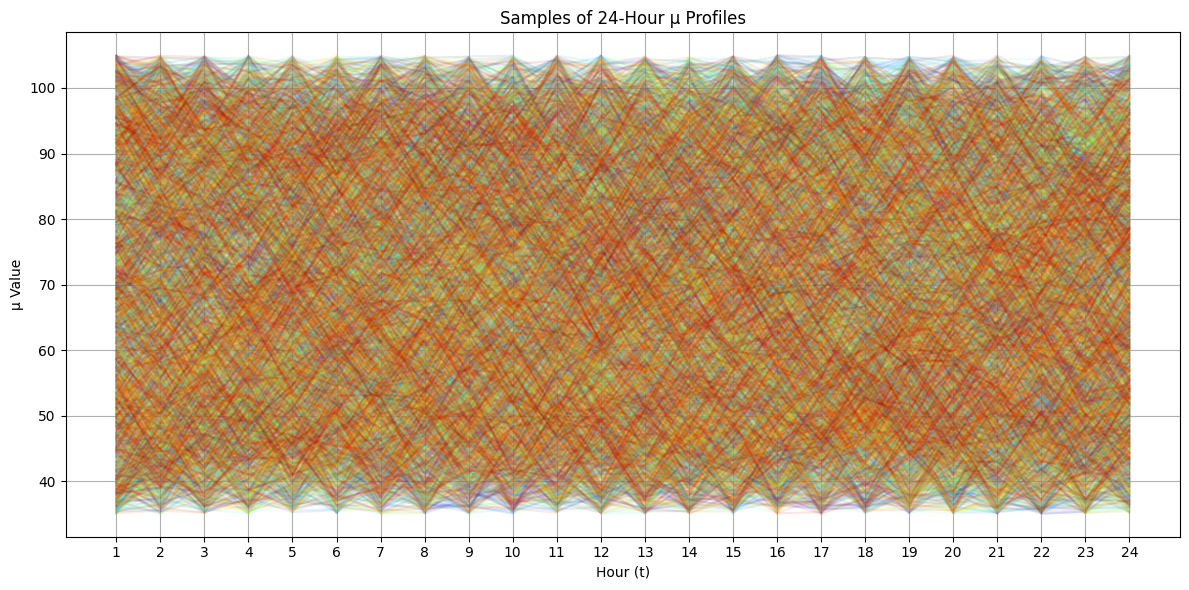

In [8]:
# mu_plot_list = mu_plot_list1
plt.figure(figsize=(12, 6))
cmap = plt.cm.get_cmap('jet', len(mu_plot_list))
for i in range(len(mu_plot_list)):
    m = mu_plot_list[i]
    plt.plot(range(1, 24+1), m, color=cmap(i), alpha=0.1)
plt.xlabel('Hour (t)')
plt.ylabel('μ Value')
plt.title(f'Samples of 24-Hour μ Profiles')
plt.xticks(range(1, 24+1))
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(storage_path, f"scenario_mu.png"))
plt.show()